In [1]:
import subprocess
import itertools
import random
from random import randrange
import statistics 
import matplotlib.pyplot as plt

In [2]:
STUDENT_ID = 12021446
"""
    Evaluation d'une liste d'individus (mots de passe)
"""
def check(student_id , passwords) :
    proc = subprocess.Popen(["./unlock64", str(student_id)] + passwords , stdout = subprocess.PIPE)
    results = []
    while True :
        line = proc.stdout.readline()
        if not line :
            break
        results.append(float(str(line).split("\\t")[1].split("\\r\\n")[0]))
    return results

print(check(STUDENT_ID , ["PASSWORD", "ALGOGEN"]))

def toStr(individu):
    length = len(individu)
    return "".join(individu) + " [" + str(length) + "]"

def toStr2(individu, score):
    return toStr(individu)+ ":" + str(score)

"""
    Trace l'ensemble des individus avec son évalation

"""
def log_list_evaluation(list_evaluation):
    print("### log_population")
    #print('log_population individus_score', list_evaluation)
    idx=0
    for individu,score in list_evaluation:
        #print("log_population : individus_score",individu )
        print(toStr2(individu,score))

"""
    Affichage sur une courbe de l'historique des valeurs obtenues
    
"""
def display_history(score_history,NB_PERSONS,ELITISM_RATE,PROB_CROSSOVER,PROB_MUTATION,PROB_ADD_GENE,PROB_REMOVE_GENE):
    # Affichage de l'évolution du score sur une graphe
    xVal,yMax,yAvg=([],[],[])
    yMax1,yAvg1=(0,0)
    idx=1
    for max_avg in score_history:
        xVal.append(idx)
        yMax.append(max_avg[0])
        yAvg.append(max_avg[1])
        if(idx==1):
            yMax1,yAvg1=max_avg[0],max_avg[1]
        idx+=1
    #print(xVal,yMax,yAvg)
    plt.figure(figsize=(20, 15))
    plt.plot(xVal, yMax, 'r')
    plt.plot(xVal, yAvg, 'g')
    plt.xlabel('#Génération')
    #plt.ylabel('max',  color='r')
    #plt.ylabel('moyenne',  color='g')
    plt.text(2, yMax1, r'max', {'color': 'r', 'fontsize': 10, 'rotation':0})
    plt.text(2, yAvg1, r'moyenne', {'color': 'g', 'fontsize': 10, 'rotation':0})
    plt.title('Evolution du score : population :' + str(NB_PERSONS) 
              + ', tx élitisme ' + str(ELITISM_RATE) 
              + ', prb coisement ' + str(PROB_CROSSOVER) 
              + ', prb mutation ' + str(PROB_MUTATION) 
              + ', prb ajout gene ' + str(PROB_ADD_GENE) 
              + ', prb supp. gene ' + str(PROB_REMOVE_GENE) 
             )
    plt.show()

    
    

[0.328869, 0.344896]


In [3]:
GENES = "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"

In [4]:
def generationIndividu(size):
    return [random.choice(GENES) for i in range(size)]

In [5]:
print(generationIndividu(18))

['1', 'G', 'C', 'Z', 'Q', '0', '2', '7', 'N', 'V', '8', 'Y', '9', 'O', 'B', '7', 'M', 'L']


In [6]:
#Le nombre d'individus à générer est passé en paramètre
def generationPopulation(nombreIndividus):
    return [generationIndividu(randrange(12,19)) for i in range(nombreIndividus)]

In [7]:
population = generationPopulation(10)

In [8]:
""" Applique une mutation de géne sur un enfant """

def child_mutation(child, prop_mutee = 1/ 100):
    mutationNB = 1 #randrange(len(child))
    if random.random() < prop_mutee:
        #child1 = toStr(child)
        for idx in range(mutationNB):
            indexGene = randrange(len(child))
            child[indexGene] = random.choice(GENES)
        #child2 = toStr(child)
            #print("mutation : ", child1, child2)
    #print("end mutation")
    #print(toStr(child))
    return child


"""
    Ajout ou suppression aléatoire d'un géne
    On s'assure que l'on a bien entre 12 et 18 genes
"""
def child_add_remove_gene(child, prob_add_gene = 1/100, prob_remove_gene = 1/100):    
    if(len(child)<18):
        if(random.random()<prob_add_gene):
            # Ajouter un gene
            gene = random.choice(GENES)
            indexGene = randrange(len(child))
            child.insert(indexGene, gene)
    if(len(child)>12):
        if(random.random()<prob_remove_gene):
            # Retirer un gene
            indexGene = randrange(len(child))
            child.remove(random.choice(child))
    return child

"""

    Création d'un enfant à partir de deux parents
    Crée l'enfant
        - Soit on croise les caractéristiques des deux parent
        - soit on part d'un des deux parents au hasaard
    Par la suite
        - on applique une mutation de gene sur l'enfant généré (un gene au hasard)
        - on applique retire ou ajoute un géne
    
    
"""
def generate_child(father, mother, prob_corssover, prob_muataion, prob_add_gene, prob_remove_gene):
    child = None
    # Copie des contenus des deux parent (pour ne pas affecter le contenu des parents)
    c_father = father.copy()
    c_mother = mother.copy()
    # Décider si on applique un croisement ou pas (tirage au sort en utilisant la prbabilité de croisement)
    if(random.random() <= prob_corssover):
        #Le nombre de gènes du père sera égal à la longueur du code secret divisé par deux
        nombreGenesPere = len(c_father)//2
        #Le nombre de gènes de la mère sera égal à la longueur du mot - le nombre de gène du père
        nombreGenesMere = len(c_mother)//2
        #print("nb gene :",nombreGenesPere +nombreGenesMere)        
        child = c_father[:nombreGenesPere] + c_mother[nombreGenesMere:]
    else:
        # Choisir aléatoirement entre le pere et la mere
        parents = [c_father, c_mother]
        child = random.choice(parents)
    #print("generate_child step1", toStr(child))
    # Appliquer une mutation de gene (avec la probabilité associée)
    child = child_mutation(child, prob_muataion)
    # Appliquer un ajout et suppression de gene (avec la probabilité associée)
    child = child_add_remove_gene(child, prob_add_gene, prob_remove_gene)
    return child



In [9]:

"""
    Fonction d'évaluation de la population
"""
def evaluation(population):    
    listPasswords = []
    for individu in population:
        nextPass = "".join(individu)
        listPasswords.append(nextPass)
    #print("evaluation nb pass:", len(listPasswords))
    result = check(STUDENT_ID , listPasswords)
    #print("evaluation", result)
    idx = 0
    list_evaluation = []
    for individu in population:
        list_evaluation.append((individu, result[idx]))
        idx+=1
    # Trier les tuples(élement,score) par score décroissant
    list_evaluation2 = sorted(list_evaluation, key=lambda tuple:-1*tuple[1])
    #print("evaluation__2", list_evaluation2)
    return list_evaluation2


In [10]:



"""
    Tirage aléatoire d'un individu
"""
def chose_one_person(list_evaluation, individus_score, individus_score_rang):
    #print("tirer_individu", individus_score)
    sumScore = sum(individus_score)
    sumScoreRang = sum(individus_score_rang)
    individus_proba = []
    #print("tirer_individu", individus_score, sumScore)
    """ 
    for score in individus_score:
        proba = (score/sumScore)
        #print("tirer_individu proba", proba)
        #proba = (score/sumScore)
        individus_proba.append(proba)
    """
    for score_rang in individus_score_rang:
        proba = (score_rang/sumScoreRang)
        #print("tirer_individu proba", proba)
        #proba = (score/sumScore)
        individus_proba.append(proba)
    #print("tirer_individu proba :", individus_proba, sum(individus_proba))
    random1 = random.random()    
    sumProba = 0
    index = 0
    for proba in individus_proba:
        sumProba = sumProba + proba
        if(sumProba > random1 ):
            #print("tirer_individu : return idx", index)
            return list_evaluation[index]
        index+=1
    #print("tirer_individu : return idx", index-1)
    return (list_evaluation[index-1])


"""
    Génération d'une liste d'enfant pour créer une nouvelle génératin
    On donne en parametre le nombre d'enfant à créer
"""
def generate_children(list_evaluation, nb_children, prob_corssover, prob_muataion, prob_add_gene, prob_remove_gene):
    individus_evaluations = []
    individus_score = []    
    individus_score_rang = []
    children = []    
    index = 0    
    # Récupérer les informations necessaire pour le tirage aléatoire : score, rang
    for individu, score in list_evaluation :
        #if score >= 0.9 :
        #    return individu
        individus_evaluations.append(individu)
        individus_score.append(score)
        individus_score_rang.append(len(list_evaluation)- index)
        index = index+1
    # Initialisation de la liste d'enfant à retourner
    children = []
    #nb_parent = len(list_evaluation)/2
    for x in range(nb_children):
        # Choisir un 1er parent
        parent1, score1 =  chose_one_person(list_evaluation, individus_score, individus_score_rang)
        # Choisir un 2e parent
        parent2, score2 =  chose_one_person(list_evaluation, individus_score, individus_score_rang)
        # Générer un enfant à partir des deux parent choisis
        new_child = generate_child(parent1, parent2, prob_corssover, prob_muataion, prob_add_gene, prob_remove_gene)
        # Ajouter l'enfant généré
        children.append(new_child)
        #print("generate_children", toStr(parent1), toStr(parent2), '->', toStr(new_child))
        #print("selection", toAdd, selected_elts)

    #print("selection parents2 ", len(selected_elts), selected_elts)
    # Retour de la liste d'enfants
    return children




In [11]:
NB_PERSONS = 1000           # Nombre d'individus de la population
PROB_MUTATION = 1            # Probabilité de mutation d'un gene
PROB_CROSSOVER = 0.9         # Probabilité de croisement des deux parents
PROB_ADD_GENE = 0.2          # Probabilité d'ajout d'un gene
PROB_REMOVE_GENE = 0.2       # Probabilité de suppression d'un gene
ELITISM_RATE = 0.2           # Taux d'élitime : correspond au taux de la population à garder pour la génération suivante (les n meilleurs individus en terme de score)
SCORE_STOP = 0.9             # Seuil du score à partir duquel on arrete le prgramme
MAX_GENERATIONS = 10000      # Seuil du nombre d'itération à partir duquelon arrete le programme

population = generationPopulation(NB_PERSONS)
idx_generation = 1
score = 0
current_max = 0
fitness_history = []
# Nombre d'individus gardés d'office d'une génération à la suivante (on trie ceux ayant les meilleurs score)
nb_to_keep = int(NB_PERSONS*ELITISM_RATE)
# Nombre d'enfant à générer pour chaque nouvelle génération : population totale - nb d'individus gardés d'office d'une génération à l'autre
nb_children = NB_PERSONS - nb_to_keep

print("------ Begin nb_to_keep = ", nb_to_keep , " nb_children to produce = " , nb_children)

while idx_generation < MAX_GENERATIONS and 1*current_max < SCORE_STOP :    
    list_evaluation = evaluation(population)
    individus_score = []
    for individu, score in list_evaluation :
        individus_score.append(score)
    # log de la population
    if(False or idx_generation%100==0):
        log_list_evaluation(list_evaluation)
    current_max,current_avg = (max(individus_score), statistics.mean(individus_score))
    fitness_history.append((current_max,current_avg))
    #print("population:", len(individus_score))
    print("generation", idx_generation ,"score max:",current_max, "score moyen:",current_avg, len(list_evaluation))

    # Ré-initialiser la population
    population = []
    # Garder ceux qui ont obetnu les meilleurs score (on ne les modifie pas)
    index = 0
    # Applicaiton de l'élitisme : on ajoute à la population les meilleurs individus qui sont gardé de-facto
    #print("step3, population size", len(population))
    best_elts = list_evaluation[:nb_to_keep]
    for individu, score in best_elts:
        #print("first_elts", toStr(individu), score)
        population.append(individu)
     
    #print("step4, population size", len(population))
    # Générer les enfants
    children = generate_children(list_evaluation, nb_children, PROB_CROSSOVER, PROB_MUTATION, PROB_ADD_GENE, PROB_REMOVE_GENE)
    population.extend(children)    
    #print("step5, population size", len(population), "ze_first", toStr(population[0]))
    """
    for elt in population:
        print("next", toStr(elt))
    """
    idx_generation+=1


theBest = list_evaluation[0]
print("Individu le plus proche",  toStr2(theBest[0], theBest[1]) )
                    
    


------ Begin nb_to_keep =  200  nb_children to produce =  800
generation 1 score max: 0.642524 score moyen: 0.470976746 1000
generation 2 score max: 0.671151 score moyen: 0.501063925 1000
generation 3 score max: 0.682542 score moyen: 0.525521221 1000
generation 4 score max: 0.684394 score moyen: 0.546381053 1000
generation 5 score max: 0.715094 score moyen: 0.564700047 1000
Individu le plus proche JZMMDP7H8F0H93 [14]:0.715094


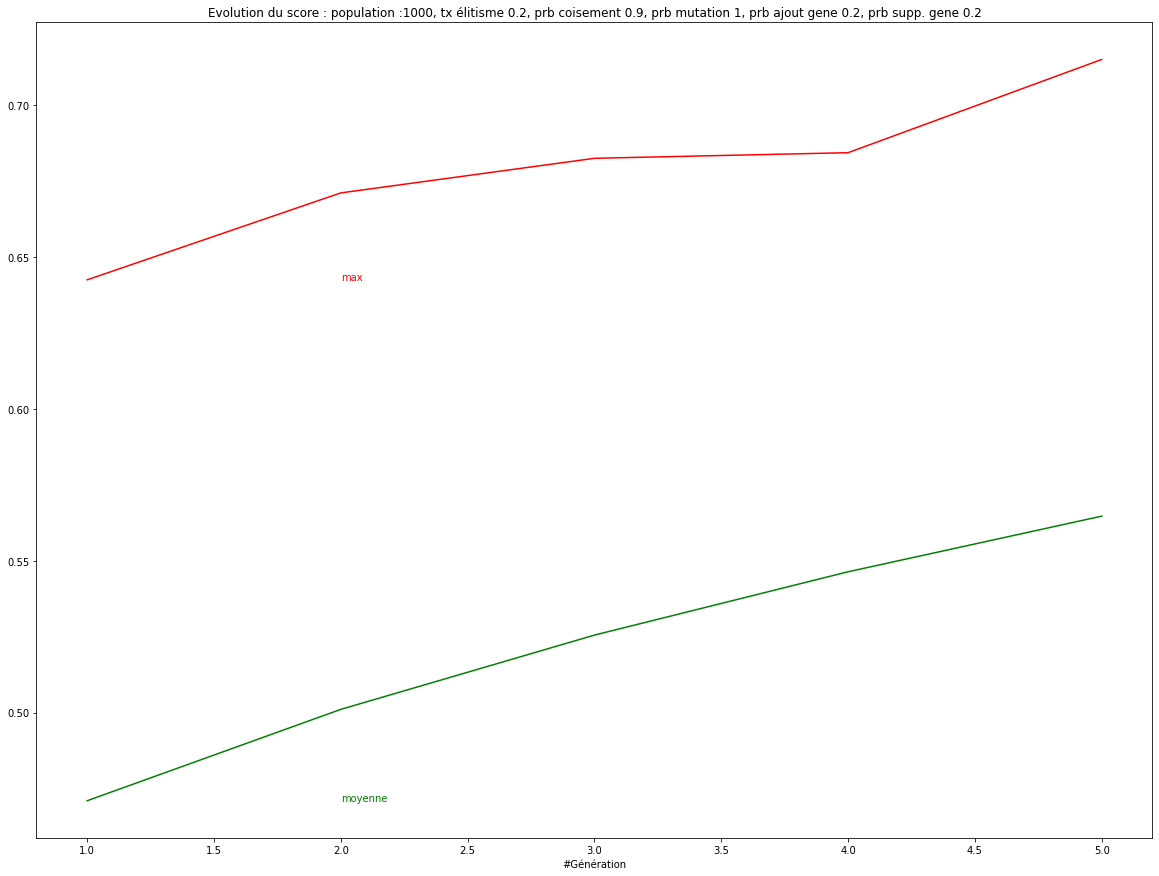

In [12]:
display_history(fitness_history,NB_PERSONS,ELITISM_RATE,PROB_CROSSOVER,PROB_MUTATION,PROB_ADD_GENE,PROB_REMOVE_GENE)
